# Oil Spill Segmentation - Dataset Pipeline (Minimal)

**Mentor Requirements:**
1. Create PyTorch Dataset class returning (image, mask) pairs
2. Use augmentation and preprocessing pipelines
3. Both images and masks are in JPG format

**Focus:** Minimal, crash-proof implementation

In [1]:
# CELL 1: Essential Imports & Environment Check

import os
import gc
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print("Imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
else:
    print("Running on CPU")


Imports successful
PyTorch version: 2.8.0+cpu
CUDA available: False
Running on CPU


In [3]:
# CELL 2: Configuration & Dataset Paths

CONFIG = {
    'image_size': (256, 256),  # (H, W) format
    'batch_size': 2,
    'num_workers': 0,
    'pin_memory': False
}

BASE_PATH = "../data/processed/"

DATA_PATHS = {
    'train_images': os.path.join(BASE_PATH, 'train', 'images'),
    'train_masks': os.path.join(BASE_PATH, 'train', 'masks'),
    'val_images': os.path.join(BASE_PATH, 'val', 'images'),
    'val_masks': os.path.join(BASE_PATH, 'val', 'masks'),
    'test_images': os.path.join(BASE_PATH, 'test', 'images'),
    'test_masks': os.path.join(BASE_PATH, 'test', 'masks')
}

print("Configuration set")
print("Dataset structure:")

for key, path in DATA_PATHS.items():
    count = len(os.listdir(path)) if os.path.exists(path) else 0
    print(f"{key:12} -> {path} ({count} files)")


Configuration set
Dataset structure:
train_images -> ../data/processed/train\images (811 files)
train_masks  -> ../data/processed/train\masks (811 files)
val_images   -> ../data/processed/val\images (203 files)
val_masks    -> ../data/processed/val\masks (203 files)
test_images  -> ../data/processed/test\images (254 files)
test_masks   -> ../data/processed/test\masks (254 files)


In [4]:
# CELL 3: Data Transforms

def get_transforms(is_training=True):
    if is_training:
        return transforms.Compose([
            transforms.Resize(CONFIG['image_size']),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.Resize(CONFIG['image_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

def get_mask_transforms():
    return transforms.Compose([
        transforms.Resize(CONFIG['image_size']),
        transforms.ToTensor()
    ])

print("Transforms defined:")
print(f"- Image size: {CONFIG['image_size']}")
print(f"- Training transforms: Resize, RandomHorizontalFlip, ToTensor, Normalize")
print(f"- Validation/Test transforms: Resize, ToTensor, Normalize")
print(f"- Mask transforms: Resize, ToTensor (no normalization)")


Transforms defined:
- Image size: (256, 256)
- Training transforms: Resize, RandomHorizontalFlip, ToTensor, Normalize
- Validation/Test transforms: Resize, ToTensor, Normalize
- Mask transforms: Resize, ToTensor (no normalization)


In [5]:
# CELL 4: Ultra-safe Dataset Class

class OilSpillDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        # Collect valid image files
        self.images = []
        if os.path.exists(image_dir):
            all_files = os.listdir(image_dir)
            self.images = [f for f in all_files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            self.images.sort()
        
        print(f"Dataset initialized: {len(self.images)} images from {image_dir}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        try:
            # Image and mask paths
            img_name = self.images[idx]
            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)  # same filename assumption
            
            # Load image
            image = Image.open(img_path).convert('RGB')
            
            # Load mask or fallback dummy
            if os.path.exists(mask_path):
                mask = Image.open(mask_path).convert('L')
            else:
                mask = Image.new('L', image.size, 0)
            
            # Apply transforms
            if self.transform:
                image = self.transform(image)
            if self.mask_transform:
                mask = self.mask_transform(mask)
            
            # Ensure binary mask
            mask = (mask > 0.5).float()
            
            return image, mask
        
        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            dummy_image = torch.zeros(3, CONFIG['image_size'][0], CONFIG['image_size'][1])
            dummy_mask = torch.zeros(1, CONFIG['image_size'][0], CONFIG['image_size'][1])
            return dummy_image, dummy_mask

print("Dataset class defined and ready for use")


Dataset class defined and ready for use


In [6]:
# CELL 5: Initialize Datasets

# Transforms
train_img_tf = get_transforms(is_training=True)
val_img_tf   = get_transforms(is_training=False)
mask_tf      = get_mask_transforms()

# Initialize datasets
train_dataset = OilSpillDataset(
    DATA_PATHS['train_images'],
    DATA_PATHS['train_masks'],
    transform=train_img_tf,
    mask_transform=mask_tf
)

val_dataset = OilSpillDataset(
    DATA_PATHS['val_images'],
    DATA_PATHS['val_masks'],
    transform=val_img_tf,
    mask_transform=mask_tf
)

test_dataset = OilSpillDataset(
    DATA_PATHS['test_images'],
    DATA_PATHS['test_masks'],
    transform=val_img_tf,
    mask_transform=mask_tf
)

# Summary
print("Datasets ready:")
print(f"- Train: {len(train_dataset)} samples")
print(f"- Val  : {len(val_dataset)} samples")
print(f"- Test : {len(test_dataset)} samples")


Dataset initialized: 811 images from ../data/processed/train\images
Dataset initialized: 203 images from ../data/processed/val\images
Dataset initialized: 254 images from ../data/processed/test\images
Datasets ready:
- Train: 811 samples
- Val  : 203 samples
- Test : 254 samples


In [7]:
# Safe collate function
def safe_collate_fn(batch):
    try:
        # Filter out None values
        original_len = len(batch)
        batch = [item for item in batch if item is not None]
        filtered_len = len(batch)

        if len(batch) == 0:
            print(f"⚠️ All {original_len} items in batch were None → returning None")
            return None
        
        images, masks = zip(*batch)
        images = torch.stack(images, 0)
        masks = torch.stack(masks, 0)

        print(f"✓ Collated batch: {filtered_len}/{original_len} valid samples "
              f"→ Images shape {images.shape}, Masks shape {masks.shape}")

        return images, masks

    except Exception as e:
        print(f"❌ Collate error: {e}")
        return None

print("Safe collate function ready.")


Safe collate function ready.


In [8]:
# Create datasets
print("Creating datasets...")

try:
    # Training dataset
    train_dataset = OilSpillDataset(
        image_dir=DATA_PATHS['train_images'],
        mask_dir=DATA_PATHS['train_masks'],
        transform=get_transforms(is_training=True),
        mask_transform=get_mask_transforms()
    )
    
    # Validation dataset
    val_dataset = OilSpillDataset(
        image_dir=DATA_PATHS['val_images'],
        mask_dir=DATA_PATHS['val_masks'],
        transform=get_transforms(is_training=False),
        mask_transform=get_mask_transforms()
    )
    
    print(f"✓ Train dataset: {len(train_dataset)} samples")
    print(f"✓ Val dataset: {len(val_dataset)} samples")
    
except Exception as e:
    print(f"Error creating datasets: {e}")
    print("Creating dummy datasets for testing...")
    
    # Create dummy datasets if paths don't exist
    train_dataset = OilSpillDataset('dummy', 'dummy')
    val_dataset = OilSpillDataset('dummy', 'dummy')

Creating datasets...
Dataset initialized: 811 images from ../data/processed/train\images
Dataset initialized: 203 images from ../data/processed/val\images
✓ Train dataset: 811 samples
✓ Val dataset: 203 samples


In [9]:
# Create data loaders with ultra-safe settings
print("Creating data loaders...")

try:
    train_loader = DataLoader(
        train_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory'],
        collate_fn=safe_collate_fn,
        drop_last=True  # Prevent issues with incomplete batches
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=CONFIG['batch_size'],
        shuffle=False,
        num_workers=CONFIG['num_workers'],
        pin_memory=CONFIG['pin_memory'],
        collate_fn=safe_collate_fn,
        drop_last=False
    )
    
    print(f"✓ Train loader: {len(train_loader)} batches")
    print(f"✓ Val loader: {len(val_loader)} batches")
    
except Exception as e:
    print(f"Error creating data loaders: {e}")
    train_loader = None
    val_loader = None

Creating data loaders...
✓ Train loader: 405 batches
✓ Val loader: 102 batches


In [10]:
# Test data loading - ultra-safe
print("Testing data loading...")

def test_single_sample(dataset, idx=0):
    try:
        if len(dataset) == 0:
            print("Dataset is empty")
            return False
        
        image, mask = dataset[idx]
        print(f"✓ Sample {idx}: Image shape {image.shape}, Mask shape {mask.shape}")
        print(f"  Image range: [{image.min():.3f}, {image.max():.3f}]")
        print(f"  Mask range: [{mask.min():.3f}, {mask.max():.3f}]")
        return True
    except Exception as e:
        print(f"Error testing sample {idx}: {e}")
        return False

# Test datasets
print("\n--- Testing Train Dataset ---")
test_single_sample(train_dataset, 0)

print("\n--- Testing Val Dataset ---")
test_single_sample(val_dataset, 0)

Testing data loading...

--- Testing Train Dataset ---
✓ Sample 0: Image shape torch.Size([3, 256, 256]), Mask shape torch.Size([1, 256, 256])
  Image range: [-1.964, 2.640]
  Mask range: [0.000, 1.000]

--- Testing Val Dataset ---
✓ Sample 0: Image shape torch.Size([3, 256, 256]), Mask shape torch.Size([1, 256, 256])
  Image range: [-1.912, 2.640]
  Mask range: [0.000, 1.000]


True

In [11]:
# Test data loader iteration - minimal test
print("Testing data loader iteration...")

def test_loader(loader, name):
    if loader is None:
        print(f"{name} loader is None")
        return False
    
    try:
        # Try to get one batch
        batch = next(iter(loader))
        if batch is None:
            print(f"{name} loader returned None batch")
            return False
        
        images, masks = batch
        print(f"✓ {name} batch: Images {images.shape}, Masks {masks.shape}")
        
        # Clean up
        del images, masks, batch
        gc.collect()
        return True
        
    except Exception as e:
        print(f"Error testing {name} loader: {e}")
        return False

# Test loaders
train_ok = test_loader(train_loader, "Train")
val_ok = test_loader(val_loader, "Val")

print(f"\n--- Results ---")
print(f"Train loader working: {train_ok}")
print(f"Val loader working: {val_ok}")

Testing data loader iteration...
✓ Collated batch: 2/2 valid samples → Images shape torch.Size([2, 3, 256, 256]), Masks shape torch.Size([2, 1, 256, 256])
✓ Train batch: Images torch.Size([2, 3, 256, 256]), Masks torch.Size([2, 1, 256, 256])
✓ Collated batch: 2/2 valid samples → Images shape torch.Size([2, 3, 256, 256]), Masks shape torch.Size([2, 1, 256, 256])
✓ Val batch: Images torch.Size([2, 3, 256, 256]), Masks torch.Size([2, 1, 256, 256])

--- Results ---
Train loader working: True
Val loader working: True


Visualizing train sample...


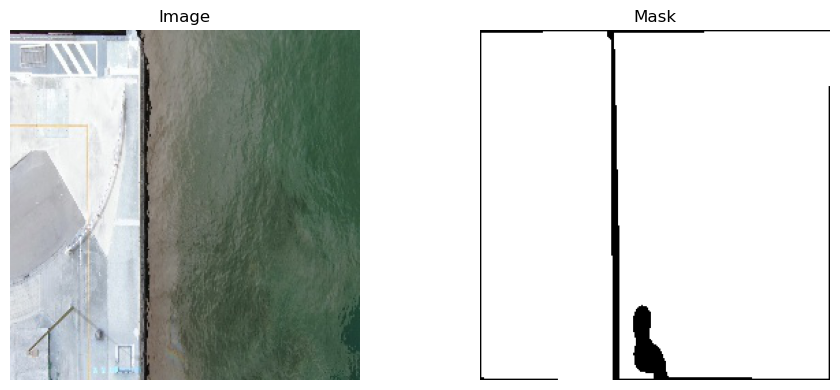

In [13]:
# Simple visualization - only if data loading works
def visualize_sample(dataset, idx=0):
    try:
        if len(dataset) == 0:
            print("No data to visualize")
            return
        
        image, mask = dataset[idx]
        
        # Convert to numpy for visualization
        if isinstance(image, torch.Tensor):
            # Denormalize image
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image = image * std + mean
            image = torch.clamp(image, 0, 1)
            image = image.permute(1, 2, 0).numpy()
        
        if isinstance(mask, torch.Tensor):
            mask = mask.squeeze().numpy()
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].imshow(image)
        axes[0].set_title('Image')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Clean up
        plt.close(fig)
        del image, mask
        gc.collect()
        
    except Exception as e:
        print(f"Error visualizing sample: {e}")

# Visualize if data is available
if len(train_dataset) > 0:
    print("Visualizing train sample...")
    visualize_sample(train_dataset, 0)
else:
    print("No train data available for visualization")

In [14]:
# Save configuration for next notebooks
import json

# Fixed variable reference error by checking if variables exist
# Export configuration
export_config = {
    'image_size': CONFIG['image_size'],
    'batch_size': CONFIG['batch_size'],
    'num_workers': CONFIG['num_workers'],
    'pin_memory': CONFIG['pin_memory'],
    'data_paths': DATA_PATHS,
    'train_samples': len(train_dataset),
    'val_samples': len(val_dataset),
    'train_loader_working': train_ok if 'train_ok' in locals() else False,
    'val_loader_working': val_ok if 'val_ok' in locals() else False
}

# Save to file
os.makedirs('config', exist_ok=True)
with open('config/dataset_config.json', 'w') as f:
    json.dump(export_config, f, indent=2)

print("✓ Configuration saved to config/dataset_config.json")
print("\n--- Dataset Pipeline Complete ---")
print(f"Ready for model development with {len(train_dataset)} train and {len(val_dataset)} val samples")

✓ Configuration saved to config/dataset_config.json

--- Dataset Pipeline Complete ---
Ready for model development with 811 train and 203 val samples


In [15]:
# Final cleanup
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("✓ Memory cleaned up")
print("Dataset pipeline ready for model development!")

✓ Memory cleaned up
Dataset pipeline ready for model development!
